In [81]:
#Imports 

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.inspection import permutation_importance

#two choices for lightgbm
import lightgbm as lgb
from sklearn.ensemble import HistGradientBoostingClassifier


In [34]:
#datas
df=pd.read_csv('cleaned_data.csv')
df

,MIS_Status,LoanNr_ChkDgt,State,Zip,UrbanRural,Bank,BankState,NAICS,NoEmp,NewExist,...,FranchiseCode,IsFranchise,Term,RevLineCr,LowDoc,DisbursementGross,ApprovalDate,ApprovalFY,GrAppv,SBA_Appv
0,1,1000014003,IN,47711,0,FIFTH THIRD BANK,OH,451120,4,2.0,...,1,1,84,0,1,60000.0,1997-02-28,1997,60000.0,48000.0
1,1,1000024006,IN,46526,0,1ST SOURCE BANK,IN,722410,2,2.0,...,1,1,60,0,1,40000.0,1997-02-28,1997,40000.0,32000.0
2,1,1000034009,IN,47401,0,GRANT COUNTY STATE BANK,IN,621210,7,1.0,...,1,1,180,0,0,287000.0,1997-02-28,1997,287000.0,215250.0
3,1,1000044001,OK,74012,0,1ST NATL BK & TR CO OF BROKEN,OK,0,2,1.0,...,1,1,60,0,1,35000.0,1997-02-28,1997,35000.0,28000.0
4,1,1000054004,FL,32801,0,FLORIDA BUS. DEVEL CORP,FL,0,14,1.0,...,1,1,240,0,0,229000.0,1997-02-28,1997,229000.0,229000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
899159,1,9995573004,OH,43221,0,JPMORGAN CHASE BANK NATL ASSOC,IL,451120,6,1.0,...,1,1,60,0,0,70000.0,1997-02-27,1997,70000.0,56000.0
899160,1,9995603000,OH,43221,0,JPMORGAN CHASE BANK NATL ASSOC,IL,451130,6,1.0,...,1,1,60,0,0,85000.0,1997-02-27,1997,85000.0,42500.0
899161,1,9995613003,CA,93455,0,"RABOBANK, NATIONAL ASSOCIATION",CA,332321,26,1.0,...,1,1,108,0,0,300000.0,1997-02-27,1997,300000.0,225000.0
899162,0,9995973006,HI,96830,0,BANK OF HAWAII,HI,0,6,1.0,...,1,1,60,0,1,75000.0,1997-02-27,1997,75000.0,60000.0


### First test based on interactive doc

In [25]:
#Encoding categorical values with LabelEncoder
label_encoders = {}
categorical_cols = ['Zip', 'State', 'Bank', 'BankState', 'RevLineCr', 'LowDoc', 'MIS_Status']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))  #Conversion in str type to avoid mistakes
    label_encoders[col] = le  # Stock the encoder if needed after for the prediction

#Selection of valuable features
features = ['Zip', 'NAICS', 'ApprovalFY', 'NewExist', 'CreateJob', 'RetainedJob', 
            'FranchiseCode', 'UrbanRural', 'RevLineCr', 'LowDoc']


X = df[features] 
y = df['MIS_Status'] 


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

#Standardisation
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

#Logistic regression 
model = LogisticRegression(max_iter=100, solver='lbfgs')
model.fit(X_train, y_train)

#Predictions and values
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

#Result
print(f"Accuracy: {accuracy:.4f}")
print("Confusion Matrix:")
print(conf_matrix)

Accuracy: 0.8245
Confusion Matrix:
[[     0  31564]
 [     1 148268]]


# Test avec LightGBM

#### Test avec HistGradientBoostingClassifier (from sklearn)

In [29]:
df.columns

Index(['MIS_Status', 'LoanNr_ChkDgt', 'State', 'Zip', 'UrbanRural', 'Bank',
       'BankState', 'NAICS', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'FranchiseCode', 'IsFranchise', 'Term', 'RevLineCr', 'LowDoc',
       'DisbursementGross', 'ApprovalDate', 'ApprovalFY', 'GrAppv',
       'SBA_Appv'],
      dtype='object')

In [62]:
#Test with HistGradientBoostRegressor
features = ['State','Zip','UrbanRural','Bank','BankState','NAICS', 'NoEmp', 'NewExist', 'CreateJob', 'RetainedJob',
       'FranchiseCode', 'IsFranchise', 'Term', 'RevLineCr', 'LowDoc',
       'DisbursementGross', 'ApprovalDate', 'ApprovalFY', 'GrAppv']

X = df[features]
y = df['MIS_Status']

label_cols = ['Zip', 'Bank', 'NoEmp', 'FranchiseCode']

for col in label_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

X['ApprovalDate']=pd.to_datetime(X['ApprovalDate'])
X['ApprovalDate']=X["ApprovalDate"].dt.year


cat_cols = ['State', 'UrbanRural', 'BankState', 'NewExist', 
            'IsFranchise', 'RevLineCr', 'LowDoc']

for col in cat_cols:
    X[col] = X[col].astype("category")


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)


model = HistGradientBoostingClassifier(max_bins=255, max_iter=100, categorical_features="from_dtype")
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.3f}')


/tmp/ipykernel_70556/286999927.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
/tmp/ipykernel_70556/286999927.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
/tmp/ipykernel_70556/286999927.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

Accuracy: 0.948


In [65]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, mean_absolute_error, mean_squared_error, r2_score
# Assuming y_true are the actual labels and y_pred are the predicted labels
y_pred = model.predict(X_test)
y_pred_labels = np.round(y_pred)  # Convert probabilities to class labels (for binary classification)

# Metrics
accuracy = accuracy_score(y_test, y_pred_labels)
precision = precision_score(y_test, y_pred_labels, average='weighted')  # 'weighted' for multi-class
recall = recall_score(y_test, y_pred_labels, average='weighted')
f1 = f1_score(y_test, y_pred_labels, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred) if len(np.unique(y_test)) == 2 else "N/A"

# Print metrics
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc}')

Accuracy: 0.9478
Precision: 0.9468
Recall: 0.9478
F1 Score: 0.9470
ROC AUC Score: 0.8953274289044645


In [73]:
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.88      0.81      0.85     15782
           1       0.96      0.98      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.92      0.90      0.91     89917
weighted avg       0.95      0.95      0.95     89917



/tmp/ipykernel_70556/2726703298.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


AttributeError: module 'matplotlib' has no attribute 'xlabel'

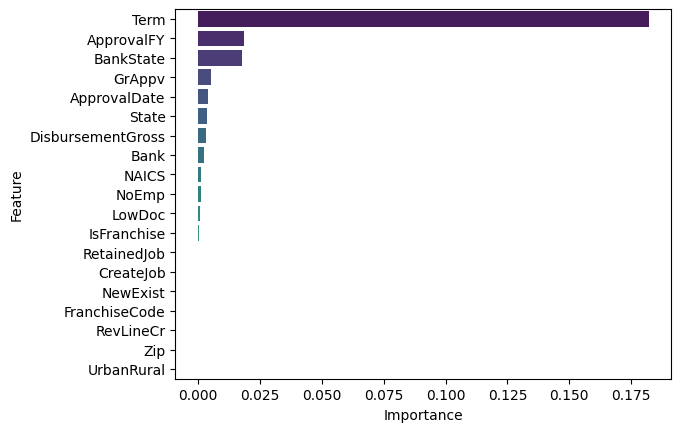

In [ ]:
# Calcul de l'importance des features par permutation
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42, scoring='accuracy')

# Extraire les importances moyennes
importances = result.importances_mean

# Créer un DataFrame pour affichage
features_names = X_test.columns
importance_df = pd.DataFrame({"Feature": features_names, "Importance": importances})

# Trier par importance décroissante
importance_df = importance_df.sort_values(by="Importance", ascending=False)

# Plot avec Seaborn
#plt.figure(figsize=(12, 6))
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - Permutation Importance")
plt.show()

In [ ]:
#features 
features = ['State', 'Zip', 'UrbanRural', 'Bank', 'BankState', 'NAICS', 'NoEmp', 'NewExist', 
            'CreateJob', 'RetainedJob', 'FranchiseCode', 'IsFranchise', 'Term', 
            'RevLineCr', 'LowDoc', 'DisbursementGross', 'ApprovalDate', 'ApprovalFY', 'GrAppv']
X = df[features]
y = df['MIS_Status']

#Label encoding
label_cols = ['Zip', 'Bank', 'NoEmp', 'FranchiseCode']
for col in label_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])

#Date transformation
X['ApprovalDate'] = pd.to_datetime(X['ApprovalDate'])
X['ApprovalYear'] = X["ApprovalDate"].dt.year
X.drop(columns=['ApprovalDate'], inplace=True)

#Categorical values scoring
cat_cols = ['State', 'UrbanRural', 'BankState', 'NewExist', 'IsFranchise', 'RevLineCr', 'LowDoc']
for col in cat_cols:
    X[col] = X[col].astype("category")


X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.1, random_state=42, stratify=y)


model = lgb.LGBMClassifier(n_estimators=100, max_bin=255, boosting_type='gbdt', 
                           categorical_feature=cat_cols, random_state=42)
model.fit(X_train, y_train)

#Prediction
y_pred = model.predict(X_test)

#Model scoring
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')
roc_auc = roc_auc_score(y_test, y_pred) if len(np.unique(y_test)) == 2 else "N/A"

#Results
print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')
print(f'ROC AUC Score: {roc_auc}')


/tmp/ipykernel_70556/3507499652.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
/tmp/ipykernel_70556/3507499652.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[col] = le.fit_transform(X[col])
/tmp/ipykernel_70556/3507499652.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/use

[LightGBM] [Warning] categorical_feature is set=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc, categorical_column=0,2,4,7,11,13,14 will be ignored. Current value: categorical_feature=State,UrbanRural,BankState,NewExist,IsFranchise,RevLineCr,LowDoc
[LightGBM] [Info] Number of positive: 667210, number of negative: 142037
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.110283 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2530
[LightGBM] [Info] Number of data points in the train set: 809247, number of used features: 18
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.824483 -> initscore=1.547017
[LightGBM] [Info] Start training from score 1.547017
Accuracy: 0.9490
Precision: 0.9480
Recall: 0.9490
F1 Score: 0.9483
ROC AUC Score: 0.89838643862616


In [77]:
print(classification_report(y_test, y_pred_labels))

              precision    recall  f1-score   support

           0       0.88      0.82      0.85     15782
           1       0.96      0.98      0.97     74135

    accuracy                           0.95     89917
   macro avg       0.92      0.90      0.91     89917
weighted avg       0.95      0.95      0.95     89917



/tmp/ipykernel_70556/1345141492.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")


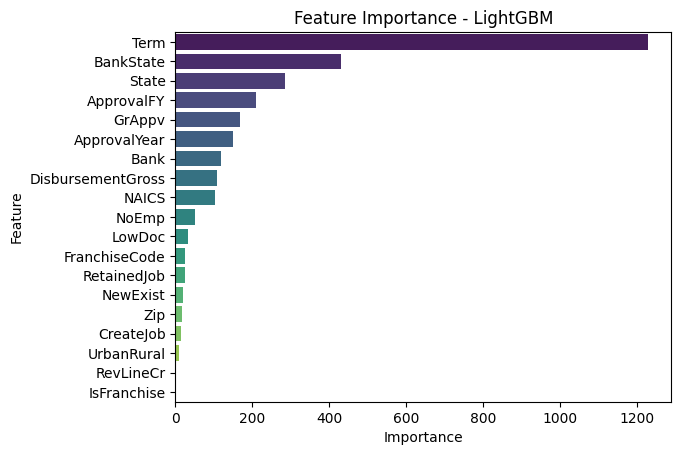

In [83]:
#Important features
importance_df = pd.DataFrame({
    "Feature": X_train.columns,
    "Importance": model.feature_importances_
}).sort_values(by="Importance", ascending=False)

#Visualization
sns.barplot(x="Importance", y="Feature", data=importance_df, palette="viridis")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Feature Importance - LightGBM")
plt.show()
